# Finding home

As an Asian parent looking for a place to live, I'm looking for a place with the best space to price ratio, while having the most number of Chinese/Asian restaurants, and located near good schools for my children. Unfortunately, most single sets of public data only have a single aspect of housing price data, restaurant info, or school grade. I would like to find the best neighborhood/zip code with a combination of these values given a budget.

In [43]:
import numpy as np
import pandas as pd
import requests
import os.path
import io
import re
import time
import json

In [45]:
# set home searching parameters
budget_max = 500000
budget_min = 300000
built_year = 1900 #built year cutoff
grade = 8 #average school grade needed
cusine = 'Chinese'
food_section = 5 #number of zipcode areas with top restuarant
interest = 'biking'

I first decided to get the property tax data from the City of New York for a complete list of properties. 
https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-data-Tax-Class/qpsp-bm9z

In [47]:
# import data from NYC Property Valuation and Assessment data 
data = pd.read_csv('TC1.txt')

I then filtered the total value (CUR_FV_L column) by max and min budget. 
Filter the building by years built after built year cutoff

In [29]:
# Filter by budget, set as 20% above and below budget

budget = data.loc[data['CUR_FV_T'] < budget_max]
budget = budget.loc[budget['CUR_FV_T'] > budget_min]

# Find places built after specified year
after_built_year = budget.loc[budget['YRB'] >= built_year]
valid_address = after_built_year[pd.notnull(after_built_year['HNUM_LO'])] # filter valid address for Zillow search
price_by_zip = valid_address.groupby(by=['ZIP'])['CUR_FV_T'].mean()

Cross check with NYC restaurant health inspection data to find the zip codes with the most number of "Grade A" restaurants. From: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/xx67-kt59

In [30]:
# imported the NYC restaurant inspection data to look at nearby restaurants
food = pd.read_csv('NYC_Restaurant_inspection.csv')

In [31]:
# find unique places by last inspection
unique_food = food
unique_food.drop_duplicates(subset = 'DBA', inplace = True)

In [32]:
# find clean Chinese places
clean_food=unique_food.loc[unique_food['GRADE'] == 'A']
chinese_food = clean_food.loc[unique_food['CUISINE DESCRIPTION'] == cusine]

In [33]:
# group places by zip code
food_by_zip=chinese_food.groupby(by=['ZIPCODE'])['GRADE'].count()

In [34]:
#combine food and mean price into one dataframe
food_and_price = pd.concat([food_by_zip, price_by_zip], axis=1)

In [35]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

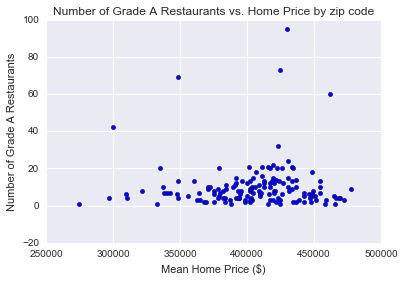

In [36]:
# make a plot for number of restaurants in zip code vs. home price
sns.plt.scatter(food_and_price['CUR_FV_T'], food_and_price['GRADE'])
sns.plt.title('Number of Grade A Restaurants vs. Home Price by zip code')
sns.plt.xlabel('Mean Home Price ($)')
sns.plt.ylabel('Number of Grade A Restaurants')

Five zip codes stand out with the most number of Chinese Restaurants. 

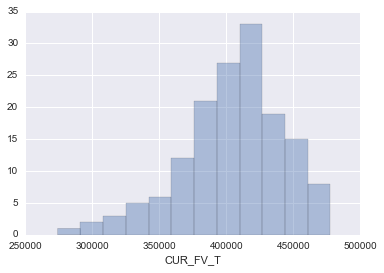

In [37]:
#look at the distribution of prices by zipcode
nonzero_price = food_and_price[pd.notnull(food_and_price['CUR_FV_T'])]
sns.distplot(nonzero_price['CUR_FV_T'], kde=False)

In [38]:
# take out invalid prices
short_list= food_and_price[pd.notnull(food_and_price['CUR_FV_T'])]
short_list= short_list.sort('GRADE', ascending=False)
short_list.head(food_section)

# the top 5 areas include 11354, 11220 , 10002, 11355, AND 11214.
# can expand to other zip codes if no valid results are found

D:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,GRADE,CUR_FV_T
11354.0,95.0,430015.242938
11220.0,73.0,424810.121908
10002.0,69.0,348208.000000
11355.0,60.0,462140.885221
10013.0,42.0,300000.000000


In [ ]:
home_with_food = valid_address.loc[valid_address['ZIP'].isin(short_list.head(food_section).index)]

Use Zillows  API to find these places and scraped each zillow page to see if the property is: 1) on the market, and 2) near a good school.

In [ ]:
# zillow API function, have 1000 request per day limit
# only use after getting small number of interested properties

from pyzillow.pyzillow import ZillowWrapper, GetDeepSearchResults, GetUpdatedPropertyDetails
# pyzillow 
# https://github.com/hanneshapke/pyzillow

YOUR_ZILLOW_API_KEY = 'X1-ZWz1fcz57zvjt7_6jziz'

zillow_link = []
zillow_link_ID = []
for i in range(len(home_with_food)):
    # sometimes zillow API wrapper dones't accept address/zipcode, even though they are strings
    try:
        # convert process street numbers for zillow API wrapper
        street_num = home_with_food.iloc[i]['HNUM_LO']

        if (street_num.isdigit() is False):
            street_num = ''.join(c for c in street_num if c.isdigit())
        number = int(street_num)

        # assing address and zipcode
        address = str(number) + ' ' + str(home_with_food.iloc[i]['STR_NAME'])
        zipcode = str(int(home_with_food.iloc[i]['ZIP']))

        #use zillow API wrapper to get website link for this property
        zillow_data = ZillowWrapper(YOUR_ZILLOW_API_KEY)
        deep_search_response = zillow_data.get_deep_search_results(address, zipcode)
        result = GetDeepSearchResults(deep_search_response)

        zillow_link.append(result.home_detail_link)
        zillow_link_ID.append(result.zillow_id)
    except:
        print "error on line", i
        pass

error on line 1
error on line 2
error on line 3
error on line 6
error on line 7
error on line 9
error on line 11
error on line 13
error on line 15
error on line 16
error on line 18
error on line 19
error on line 22
error on line 23
error on line 27
error on line 29
error on line 30
error on line 31
error on line 32
error on line 33
error on line 35
error on line 36
error on line 37
error on line 38
error on line 41
error on line 42
error on line 43
error on line 44
error on line 45
error on line 46
error on line 49
error on line 50
error on line 51
error on line 52
error on line 54
error on line 56
error on line 57
error on line 59
error on line 61
error on line 62
error on line 63
error on line 65
error on line 67
error on line 70
error on line 71
error on line 74
error on line 75
error on line 76
error on line 77
error on line 80
error on line 85
error on line 86
error on line 87
error on line 89
error on line 90
error on line 91
error on line 93
error on line 94
error on line 95
err

In [ ]:
links = pd.DataFrame(list(zillow_link))
links.columns=['Zillow Links']
links['Zillow ID'] = zillow_link_ID

In [ ]:
links.drop_duplicates(subset = 'Zillow ID', inplace = True)

In [ ]:
len(zillow_link)

Scrap the Zillow pages to nearby school ratings for the property

In [ ]:
from bs4 import BeautifulSoup

ratings = []
status = []

for i in range(len(links)):

    rate = []

    #scrapying zillow page for school rating
    r = requests.get(links['Zillow Links'][i])

    #parse with BeautifulSoup

    soup = BeautifulSoup(r.text, "html.parser")

    #check if selling
    sale_tag = soup.find(id = 'home-value-wrapper')

    if ('For Sale' in sale_tag.text):
        status.append('For Sale')
    elif ('Off Market' in sale_tag.text):
        status.append('Off Market')
    elif ('Sold' in sale_tag.text):
        status.append('Sold')
    elif ('PENDING' in sale_tag.text):
        status.append('Pending')
    else:
        status.append('Unknown')

    #find id='nearbySchools'
    rating = soup.find(id = 'nearbySchools')

    #find 'li' in the table
    rows = rating.find_all('li')

    #find each row by 'div', first char of each striped value is grade
    #get a list of all three, pk-5, 6-8, 9-12 in random order
    rate=[]
    for row in rows[1:4]:
        score = row.find_all('div')[0].text.strip()
        rate.append(int(score[0:2]))
    # print rate
    ratings.append(rate)

In [ ]:
links['School Rating'] = ratings
links['Status'] = status

At the end, I was able to find a property in Flushing, Queen in a relatively good area. It is close to elementry and middle school with scores of 10 and 9. Although the score of 3 for high school is low, I may need to consider other options later. For now, this seems to be a nice place to look. 

In [ ]:
links

In [ ]:
#save the zillow results in a csv
today_date = time.strftime("%d_%m_%Y")
links
filename = 'Zillow' + today_date + '.csv'
links.to_csv(filename)

In [ ]:
links_sale = links.loc[links['Status'] == 'For Sale']

In [ ]:
for i in links_sale['Zillow Links']:
    print i

# Result

This is the result using current criteria. If this property is not of interest, I will need to relax other criteris (e.g. more zip codes) to find a more appropriate place to live.

Future work:
1. Cross check properties with nearby restaurant ratings using yelp data
2. Scrap transport rating of the property on each zillow page
3. Scrap greatschool.org to circumvent zillow's 1000 request per day limit for school data

This later work include import of Yelp data from:
https://www.yelp.com/dataset_challenge/dataset

## Continuation

Use Yelp API to find restaurants and other activities close by. Unfortunately Yelp API only return 20 result for each request. And the maximum is 1000 total responses. This is not bad for small towns, but NYC have 3624 Chinese restaurants (indicated in the 'total' field). So we need to find all of them if possbile.

Load the offical Yelp API for requesting data

In [ ]:
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator

# read API keys
with io.open('config_secret.json') as cred:
    creds = json.load(cred)
    auth = Oauth1Authenticator(**creds)
    client = Client(auth)

In [ ]:
# set parameters to be Chinese Restaurants
params = {
    'term': 'restaurants',
    'category_filter': cusine.lower(),
    'location': 'New York, NY',
    'sort': '0',
    'offset': '0'
}

response = client.search(**params)

In [ ]:
# find the total number of results
yelp_counter = response.total

In [ ]:
yelp_responses = []
# find the number of request or offset needed to get all responses
request_count = response.total / 20

In [ ]:
request_count

In [ ]:
# loop until get all responses by offset
get_counter = 0
while (get_counter < request_count):
    # set parameters to be Chinese Restaurants
    params = {
        'term': 'restaurants',
        'category_filter': cusine.lower(),
        'location': 'New York, NY',
        'sort': '0',
        'offset': str(get_counter * 20)
    }
    response = client.search(**params)
    yelp_responses.append(response)
    get_counter += 1
    
    # maximum 1000 respones
    if (get_counter == 50):
        break

In [ ]:
# test to see if the business name make sense
# yelp_responses[179].businesses[0].name

In [ ]:
# loop through each list of yelp.responses and each business in each responese
yelp_names = []
yelp_rating = []
yelp_zipcode = []
for i in yelp_responses:
    for j in i.businesses:
        yelp_names.append(j.name)
        yelp_rating.append(j.rating)
        yelp_zipcode.append(j.location.postal_code)

In [ ]:
# make a dataframe out of the info
yelp_data = pd.DataFrame(list(yelp_names))
yelp_data.columns=['Restaurant name']
yelp_data['ratings'] = yelp_rating
yelp_data['zipcode'] = yelp_zipcode

In [ ]:
# group by zipcode, find the average ratings and count of restaurants per zipcode
count_by_zip = yelp_data.groupby(by=['zipcode'])['ratings'].count()
rating_by_zip = yelp_data.groupby(by=['zipcode'])['ratings'].mean()

In [ ]:
# make a dataframe out of the info
yelp_cm = pd.DataFrame(list(count_by_zip))
yelp_cm.columns=['Count']
yelp_cm['Average Rating'] = list(rating_by_zip)

In [ ]:
# graph the # of restaurants vs rating
sns.plt.scatter(yelp_cm['Average Rating'], yelp_cm['Count'])
sns.plt.xlabel('Average Rating')
sns.plt.ylabel('Number of Restaurants per zipcode')

This data is not as complete as the health inspection data because Yelp have a 1000 places limit

In [ ]:
# clearn zip code that doesn't make sense
cleaned_data = data.loc[data['ZIP'] < 15000]
cleaned_data = cleaned_data.loc[cleaned_data['ZIP'] > 10000]

# look at house price between 100,000 and 1 million
price_range = cleaned_data.loc[cleaned_data['CUR_FV_T'] < 1000000]
price_range = price_range.loc[price_range['CUR_FV_T'] > 100000]
sns.distplot(price_range['CUR_FV_T'], kde=False)
sns.plt.xlim((0, 1000000))
#sns.plt.ylim((0, 50))
# most houses are between $300,000 and $800,000

In [ ]:
# find built year distribution
year_built = price_range.loc[price_range['YRB'] < 2015]
year_built = year_built.loc[year_built['YRB'] > 1900]
sns.distplot(year_built['YRB'])

Where as built year is continous after about 1980, built year between 1900 and 1980 always have a huge gap in between. It is either due to record keeping, or could be some other reason that resulted in this. Superfacial search on google showed the record keeping have may errors and these years are just an estimate.  

In [ ]:
sns.distplot(yelp_cm['Count'], kde=False)

#Machine Learning parts

Used some machine learning to figure out what determine the price of a house. 

In [51]:
# only get numeric and drop NaN columns
num_data = data._get_numeric_data()
num_data=num_data.dropna(axis=1,how='any')

In [52]:
from sklearn.cross_validation import train_test_split

X = num_data.drop('CUR_FV_T', axis=1)
y = num_data.CUR_FV_T #use current value as label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [53]:
# use KNN to fit the data
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

In [54]:
knn_y = knn_model.predict(X_test)

knn_sum_squares = ((knn_y - y_test) ** 2).sum()
mean_sum_squares = ((y_test.mean() - y_test) ** 2).sum()

print "Average loss:", mean_sum_squares
print "KNN loss:", knn_sum_squares
print "Variation explained: ", 100 * (1 - knn_sum_squares / mean_sum_squares), "%"

Average loss: 7.91697928187e+16
KNN loss: 3.8202339381e+15
Variation explained:  95.1746318866 %


In [55]:
print "R^2: ", knn_model.score(X_test, y_test)

R^2:  0.951746318866


In [56]:
# use GLM to fit the data
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [57]:
print linear_model.score(X_test, y_test)

0.993441143383


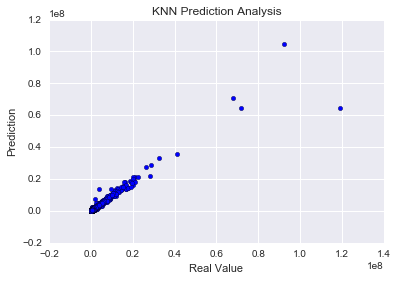

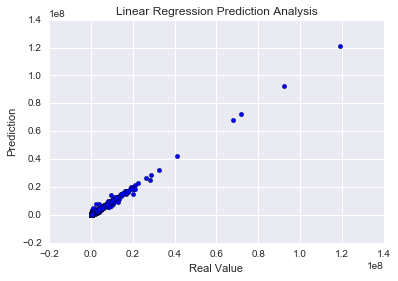

In [58]:
# compare KNN and GLM
sns.plt.scatter(y_test, knn_model.predict(X_test))
sns.plt.title('KNN Prediction Analysis')
sns.plt.xlabel('Real Value')
sns.plt.ylabel('Prediction')
plt.show()

sns.plt.scatter(y_test, linear_model.predict(X_test))
sns.plt.title('Linear Regression Prediction Analysis')
sns.plt.xlabel('Real Value')
sns.plt.ylabel('Prediction')
plt.show()

In [61]:
# use Pipeline to run preprocessing and GLM together

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
pipeline = make_pipeline(StandardScaler(), LinearRegression())
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.99344114338294087

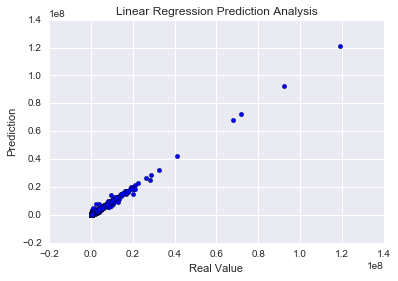

In [62]:
sns.plt.scatter(y_test, pipeline.predict(X_test))
sns.plt.title('Linear Regression Prediction Analysis')
sns.plt.xlabel('Real Value')
sns.plt.ylabel('Prediction')
plt.show()